<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#NLP-Модель" data-toc-modified-id="NLP-Модель-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>NLP Модель</a></span></li><li><span><a href="#Классификатор-NLP-модели" data-toc-modified-id="Классификатор-NLP-модели-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Классификатор NLP модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Константная-модель" data-toc-modified-id="Константная-модель-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Константная модель</a></span></li><li><span><a href="#RidgeClassifier" data-toc-modified-id="RidgeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RidgeClassifier</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

🚩 Проект выполнен в среде google colab на GPU.

На всем объеме данных эмбеддинги и логиты для модели `martin-ha/toxic-comment-model` обрабатываются на картах:
*   Т4: 40 минут
*   V100: 14 минут

Можно ускорить обработку выбрав часть данных (оставил для этого закомментированную строчку кода после загрузки данных).

Без GPU проект не будет работать. Можно было бы используя признак torch.cuda.is_available() обеспечить возможность работы и на CPU, но на нем даже первые 100 записей обрабатываются очень долго.


## Подготовка

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.3 MB/s eta 0:00:00


In [2]:
import math
import numpy as np
import pandas as pd
import torch

from transformers import __version__ as transformers_version
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from tqdm import notebook

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [3]:
RANDOM_STATE = 12345
BATCH_SIZE = 100
# Максимальная длина последовательности токенов
MAX_LENGTH = 512
MODEL_PATH = 'martin-ha/toxic-comment-model'

In [4]:
# Версии библиотек
transformers_version, torch.__version__

# Наличие GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sun Sep  3 10:30:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
data = pd.read_csv('datasets/toxic_comments.csv', index_col=0)

In [6]:
data.sample(10, random_state=RANDOM_STATE)

,text,toxic
109583,Expert Categorizers \n\nWhy is there no menti...,0
105077,"""\n\n Noise \n\nfart* talk. """,1
82244,"An indefinite block is appropriate, even for a...",0
18740,I don't understand why we have a screenshot of...,0
128310,"Hello! Some of the people, places or things yo...",0
108406,"""::::::::::::::If you read carefully, my comme...",1
25283,"""\nDid you make it at WP:AE? ofShalott """,0
32695,know as much as he thinks.,0
31936,Thank you for your comment and willingness to ...,0
20244,UPDATE 3-12-06\n\nHEY YALL IM GOING TO BE GONE...,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


### NLP Модель

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

model.to('cuda')

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [9]:
logits = []
features = []
batches_count = math.ceil(data.shape[0] / BATCH_SIZE)
# Обрабатываем тексты батчами.
for i in notebook.tqdm(range(batches_count)):
    batch_slice = slice(BATCH_SIZE * i, BATCH_SIZE * (i + 1))
    tokens = tokenizer(
        data.iloc[batch_slice]['text'].tolist(),
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    ).to('cuda')

    with torch.no_grad():
        batch_outputs = model(**tokens, output_hidden_states=True)

    # Получаем логиты, отсоединяем от GPU
    logits.append(batch_outputs.logits.cpu().numpy())

    # Получаем эмбеддинги (последний слой модели), отсоединяем от GPU
    features.append(batch_outputs.hidden_states[-1][:,0,:].cpu().numpy())

  0%|          | 0/1593 [00:00<?, ?it/s]

In [10]:
logits = np.concatenate(logits, axis=0)
logits.shape

(159292, 2)

In [11]:
features = np.concatenate(features, axis=0)
features.shape

(159292, 768)

### Классификатор NLP модели

In [12]:
# Преобразуем логиты в метки классов (0/1 - нормальный/токсичный комментарий)
preds = np.apply_along_axis(lambda x: x.argmax(), 1, logits)
print('F1 встроенного классификатора:', f1_score(data['toxic'], preds))

F1 встроенного классификатора: 0.7023705004389815


### Выводы

- Загружены комментарии в количестве 160 тыс (примерно).
- Данные обработаны с помощью NLP модели: получены эмбеддинги и логиты.
- F1 классификатора NLP модели не достигает значения 0.75 на всем объеме данных. Улучшим результаты на модели логистической регрессии.

## Обучение

In [13]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

В данных присутствует выраженный дисбаланс классов. Как показывают разнообразные эксперименты, в этом случае лучше не бороться с дисбалансом классов, оставить как есть.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    data['toxic'],
    test_size=0.2,
    stratify=data['toxic'],
    random_state=RANDOM_STATE)

### Константная модель

In [15]:
dummy_model = DummyClassifier(
    strategy='stratified',
    random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)
print('F1 константной модели:', f1_score(y_train, dummy_model.predict(X_train)))

F1 константной модели: 0.10188506448904831


### RidgeClassifier

In [16]:
%%time

ridge_model = RidgeClassifier(
    solver='sparse_cg',
    max_iter=1000,
    random_state=RANDOM_STATE)

ridge_params = {
    'alpha': np.arange(0, 0.05, 0.01)
}

ridge_gs = GridSearchCV(
    ridge_model,
    param_grid=ridge_params,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=3,
    error_score='raise'
)

ridge_gs.fit(X_train, y_train)
print('F1 модели Ridge:', ridge_gs.best_score_)
print('Лучшие параметры: ', ridge_gs.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
F1 модели Ridge: 0.7524867475230547
Лучшие параметры:  {'alpha': 0.01}
CPU times: user 20.8 s, sys: 1.49 s, total: 22.2 s
Wall time: 2min 18s


## Тестирование

In [17]:
y_pred = ridge_gs.predict(X_test)
print('F1 модели Ridge на тестовой выборке:', f1_score(y_test, y_pred))

F1 модели Ridge на тестовой выборке: 0.7519025875190259


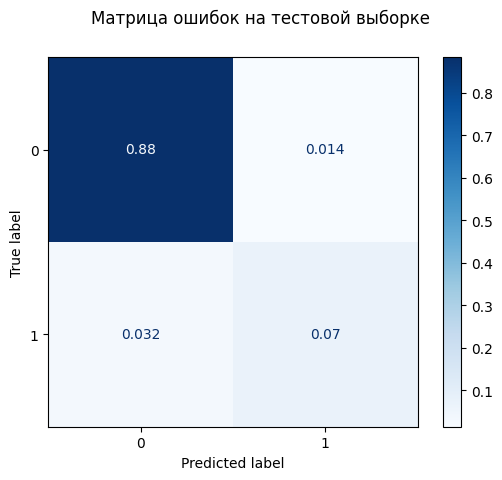

In [18]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize='all',
    cmap=plt.cm.Blues
)
plt.suptitle('Матрица ошибок на тестовой выборке')
plt.show()

**Вывод**

Модель Ridge проходит тестирование и показывает довольно высокую точность: отрицательный класс - 0.88 (доля 0.9 в всей выборке), положительный класс - 0.07 (доля 0.1 во всей выборке).

## Выводы

* Метрика F1 встроенного в NLP модель классификатора не превосходит пороговое значение 0.75.
* Классы целевого признака несбалансированны, дисбаланс классов оставлен как есть.
* Модель Ridge проходит проверку на адекватность, ее метрика выше метрики константной модели.
* Ridge проходит тестирование, ее метрика F1 равна пороговой 0.75.
* Сочетание NLP модели и ее последующее дообучение на модели логистической регрессии позволяет повысить точность предсказания.